In [666]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import yfinance as yf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime,timedelta
from copy import deepcopy as dc

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [667]:
ticker="AMZN"
current_date = datetime.now()
data: pd.DataFrame = yf.download(ticker,
                                 start=current_date - timedelta(days=3625),
                                 end=current_date,
                                 interval="1d")
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-08-13,16.379999,16.586000,16.306999,16.313999,16.313999,98782000
2014-08-14,16.389999,16.704500,16.335501,16.660500,16.660500,68408000
2014-08-15,16.700001,16.750000,16.416000,16.681499,16.681499,77934000
2014-08-18,16.774000,16.889999,16.688499,16.726500,16.726500,49708000
2014-08-19,16.743500,16.790501,16.650499,16.756500,16.756500,34276000
...,...,...,...,...,...,...
2024-07-09,199.399994,200.570007,199.050003,199.339996,199.339996,32700100
2024-07-10,200.000000,200.110001,197.690002,199.789993,199.789993,32883800
2024-07-11,200.089996,200.270004,192.860001,195.050003,195.050003,44565000


In [668]:
data = data.reset_index()
data["Date"] = pd.to_datetime(data["Date"])
data = data.drop(columns=["Adj Close"])
data

,Date,Open,High,Low,Close,Volume
0,2014-08-13,16.379999,16.586000,16.306999,16.313999,98782000
1,2014-08-14,16.389999,16.704500,16.335501,16.660500,68408000
2,2014-08-15,16.700001,16.750000,16.416000,16.681499,77934000
3,2014-08-18,16.774000,16.889999,16.688499,16.726500,49708000
4,2014-08-19,16.743500,16.790501,16.650499,16.756500,34276000
...,...,...,...,...,...,...
2491,2024-07-09,199.399994,200.570007,199.050003,199.339996,32700100
2492,2024-07-10,200.000000,200.110001,197.690002,199.789993,32883800
2493,2024-07-11,200.089996,200.270004,192.860001,195.050003,44565000
2494,2024-07-12,194.800003,196.470001,193.830002,194.490005,30554000


In [669]:
def sma(data: pd.DataFrame, period: int):
    data[f"SMA-{period}"] = data["Close"].rolling(window=period).mean()

def std(data: pd.DataFrame, period:int):
    data[f"STD-{period}"] = data["Close"].rolling(window=period).std()

def bb(data: pd.DataFrame, period: int):
    data[f'Lower_BB-{period}'] = data[f"SMA-{period}"] - 2 * data[f"STD-{period}"]
    data[f'Upper_BB-{period}'] = data[f"SMA-{period}"] + 2 * data[f"STD-{period}"]

def ema(data: pd.DataFrame, period: int):
    data[f"EMA-{period}"] = data["Close"].ewm(span=period,adjust=False).mean()

def rsi(data: pd.DataFrame, period: int):
    # 
    delta = data["Close"].diff()
    delta = delta.dropna()

    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0], loss[loss > 0] = 0, 0

    avg_gain = gain.ewm(com=14, min_periods=period).mean()
    avg_loss = abs(loss.ewm(com = 14, min_periods=period).mean())

    data[f"RSI-{period}"] = 100 - (100/(1 + (avg_gain/avg_loss)))

In [670]:
period = 20
sma(data,period)
std(data,period)
bb(data,period)
ema(data,period)
rsi(data,period)

# removing unnecessary features
features = data.columns.tolist()
features.remove("Open")
features.remove("Close")
features.append("Close")

# selecting features
data = data.dropna()
data = data[features]
data = data.set_index("Date")
data

,High,Low,Volume,SMA-20,STD-20,Lower_BB-20,Upper_BB-20,EMA-20,RSI-20,Close
Date,,,,,,,,,,
2014-09-11,16.650499,16.319500,54404000,16.856300,0.262182,16.331936,17.380664,16.788587,44.335795,16.525999
2014-09-12,16.644501,16.439501,68586000,16.851250,0.267079,16.317092,17.385407,16.766769,45.366089,16.559500
2014-09-15,16.566500,15.950000,80008000,16.826900,0.303136,16.220628,17.433172,16.712267,37.305599,16.194500
2014-09-16,16.474001,16.004999,65198000,16.809975,0.318116,16.173743,17.446207,16.681385,43.052786,16.388000
2014-09-17,16.400000,16.076000,82720000,16.782150,0.346143,16.089864,17.474436,16.635539,39.302337,16.200001
...,...,...,...,...,...,...,...,...,...,...
2024-07-09,200.570007,199.050003,32700100,191.038000,6.435778,178.166444,203.909555,192.536519,64.129895,199.339996
2024-07-10,200.110001,197.690002,32883800,191.674500,6.647658,178.379184,204.969815,193.227326,64.634724,199.789993
2024-07-11,200.270004,192.860001,44565000,192.065500,6.602306,178.860887,205.270112,193.400914,55.775676,195.050003


In [671]:
data["Close"] = data["Close"].shift(-1)
data = data.iloc[:-1]
data

,High,Low,Volume,SMA-20,STD-20,Lower_BB-20,Upper_BB-20,EMA-20,RSI-20,Close
Date,,,,,,,,,,
2014-09-11,16.650499,16.319500,54404000,16.856300,0.262182,16.331936,17.380664,16.788587,44.335795,16.559500
2014-09-12,16.644501,16.439501,68586000,16.851250,0.267079,16.317092,17.385407,16.766769,45.366089,16.194500
2014-09-15,16.566500,15.950000,80008000,16.826900,0.303136,16.220628,17.433172,16.712267,37.305599,16.388000
2014-09-16,16.474001,16.004999,65198000,16.809975,0.318116,16.173743,17.446207,16.681385,43.052786,16.200001
2014-09-17,16.400000,16.076000,82720000,16.782150,0.346143,16.089864,17.474436,16.635539,39.302337,16.250000
...,...,...,...,...,...,...,...,...,...,...
2024-07-08,201.199997,197.960007,34767300,190.286000,6.291736,177.702528,202.869472,191.820364,64.076713,199.339996
2024-07-09,200.570007,199.050003,32700100,191.038000,6.435778,178.166444,203.909555,192.536519,64.129895,199.789993
2024-07-10,200.110001,197.690002,32883800,191.674500,6.647658,178.379184,204.969815,193.227326,64.634724,195.050003


In [672]:
data = data.to_numpy()
scaler = MinMaxScaler(feature_range=(-1,1))
data = scaler.fit_transform(data)
data

array([[-0.97718544, -0.97706789, -0.83992026, ..., -0.97908533,
        -0.3349376 , -0.97617053],
       [-0.97724971, -0.97576953, -0.77819176, ..., -0.97932967,
        -0.30394141, -0.98010261],
       [-0.97808538, -0.98106573, -0.72847642, ..., -0.97994005,
        -0.54643973, -0.97801806],
       ...,
       [ 0.98832224,  0.98528536, -0.93358898, ...,  0.99689433,
         0.27575181,  0.9466746 ],
       [ 0.99003645,  0.93302675, -0.88274544, ...,  0.99883838,
         0.00922902,  0.94064185],
       [ 0.94932482,  0.94352176, -0.94372965, ...,  1.        ,
        -0.01938737,  0.92189594]])

In [673]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
    
model = RNN(1,4,1).to(device)
model

RNN(
  (rnn): RNN(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [674]:
X = data[:, 1:]
y = data[:, 0]

X.shape, y.shape

((2475, 9), (2475,))

In [675]:
split_index = int(len(X) * 0.75)

# splitting the data
X_train, X_test = np.array(X[:split_index]), np.array(X[split_index:])
y_train, y_test = np.array(y[:split_index]), np.array(y[split_index:])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1856, 9), (619, 9), (1856,), (619,))

In [676]:
# reshaping the data
num_of_features = X.shape[1]
X_train = X_train.reshape((-1, num_of_features, 1))
X_test = X_test.reshape((-1, num_of_features, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [677]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1856, 9, 1), (619, 9, 1), (1856, 1), (619, 1))

In [678]:
X_train = torch.tensor(X_train,device=device).float()
y_train = torch.tensor(y_train,device=device).float()
X_test = torch.tensor(X_test,device=device).float()
y_test = torch.tensor(y_test,device=device).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1856, 9, 1]),
 torch.Size([619, 9, 1]),
 torch.Size([1856, 1]),
 torch.Size([619, 1]))

In [679]:
class RNNDataset(Dataset):
    def __init__(self, X, y) -> None:
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
train_dataset = RNNDataset(X_train, y_train)
test_dataset = RNNDataset(X_test, y_test)

In [680]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [681]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [682]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [683]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.246

Val Loss: 0.137
***************************************************

Epoch: 2
Batch 100, Loss: 0.043

Val Loss: 0.016
***************************************************

Epoch: 3
Batch 100, Loss: 0.008

Val Loss: 0.016
***************************************************

Epoch: 4
Batch 100, Loss: 0.005

Val Loss: 0.013
***************************************************

Epoch: 5
Batch 100, Loss: 0.005

Val Loss: 0.011
***************************************************

Epoch: 6
Batch 100, Loss: 0.004

Val Loss: 0.010
***************************************************

Epoch: 7
Batch 100, Loss: 0.004

Val Loss: 0.009
***************************************************

Epoch: 8
Batch 100, Loss: 0.003

Val Loss: 0.007
***************************************************

Epoch: 9
Batch 100, Loss: 0.003

Val Loss: 0.007
***************************************************

Epoch: 10
Batch 100, Loss: 0.003

Val Loss: 0.007
********************************

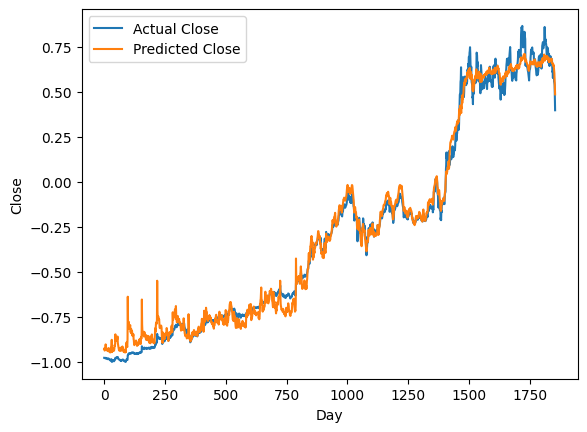

In [684]:
with torch.no_grad():
    predicted = model(X_train).to('cpu').numpy()

plt.plot(y_train.cpu(), label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [685]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], num_of_features+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 21.36286341,  21.6584727 ,  20.41391386, ..., 160.19159899,
       156.80974504, 153.18220835])

In [686]:
dummies = np.zeros((X_train.shape[0], num_of_features+1))
dummies[:, 0] = y_train.cpu().flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 16.6505006 ,  16.64450319,  16.56649781, ..., 157.99999887,
       150.89999325, 144.94500769])

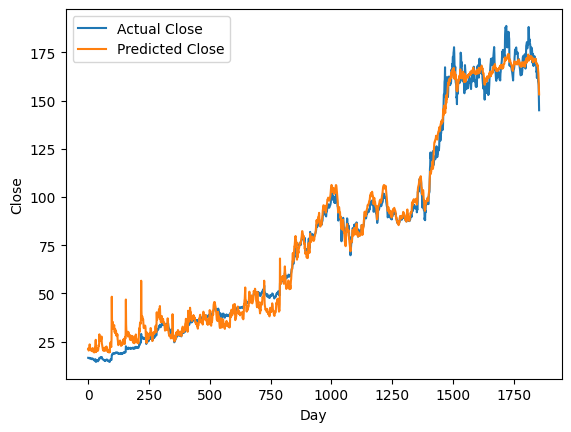

In [687]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [688]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], num_of_features+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([152.62936657, 150.91000471, 151.63292169, 152.63531948,
       152.98545075, 153.85204985, 149.56831329, 150.84011643,
       149.5493975 , 156.7061477 , 156.8992501 , 157.13401731,
       155.81865222, 156.82610163, 157.24477483, 158.50155104,
       157.20521301, 156.65667179, 156.07725888, 154.34477837,
       156.95761088, 156.80705232, 158.63993117, 158.43552381,
       159.13556381, 157.52382724, 156.54616463, 154.37375291,
       151.89674133, 151.18463972, 153.48597368, 151.95756116,
       152.48370386, 153.92028579, 155.56692756, 156.88329964,
       158.60349602, 157.67022432, 159.39397576, 158.11525166,
       158.51454174, 158.37338544, 159.61164087, 158.48576748,
       156.98481624, 156.51083661, 157.30687425, 159.14228448,
       158.19134321, 158.93808297, 159.98109963, 159.58783479,
       159.73557267, 160.44948797, 162.16129464, 160.40630433,
       160.85860869, 162.13743849, 160.03820306, 158.48867718,
       156.6017548 , 156.03834243, 153.01161018, 151.32

In [689]:
dummies = np.zeros((X_test.shape[0], num_of_features+1))
dummies[:, 0] = y_test.cpu().flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([143.600006  , 145.18499621, 144.24349892, 143.99799979,
       150.36050379, 151.70799235, 155.07499462, 144.24749627,
       161.19999419, 162.6909924 , 161.79249793, 163.83450198,
       160.7165066 , 158.9999988 , 158.44850338, 158.00700327,
       158.83400161, 160.34900062, 155.49949833, 152.98249933,
       151.76300113, 151.74899232, 153.99000438, 154.44999745,
       154.09899827, 152.99949573, 153.92900096, 147.8500057 ,
       146.09449799, 140.69949214, 140.25000012, 148.67450048,
       149.6750039 , 147.44999794, 147.98500046, 153.14999309,
       157.49850233, 161.59399341, 163.08400132, 166.16700804,
       166.36999672, 164.11850031, 165.36850022, 169.037507  ,
       170.83149721, 168.95049992, 166.49499671, 165.82699672,
       168.39449809, 168.11050532, 162.19999969, 160.07899441,
       157.36850078, 154.13650439, 155.09900099, 156.02499567,
       155.89700253, 154.03950533, 158.64899962, 157.60249467,
       156.73800412, 149.61500469, 146.22149527, 144.85

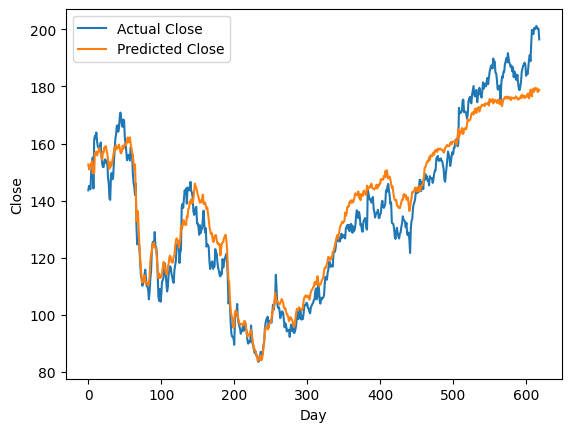

In [690]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [691]:
predicted_price = test_predictions[-1]

In [692]:
def evaluate_model(model, X_test: torch.Tensor, y_test: torch.Tensor):
    # Ensure the model is in evaluation mode
    model.eval()

    # Perform the forward pass
    with torch.no_grad():
        predictions: torch.Tensor = model(X_test)

    # Detach the predictions tensor and convert to numpy
    predictions_np = predictions.detach().cpu().numpy()

    return mean_squared_error(y_test.cpu(), predictions_np)

mse = evaluate_model(model, X_test, y_test)

In [693]:
def get_current_price(symbol:str):
    todays_data = yf.Ticker(symbol).history(period='1d')
    return todays_data['Close'].iloc[0]

current_price = get_current_price(ticker)

In [694]:
print(f'{ticker} Stock Prices')
print(f'\nStock Price Now: {current_price: 0.2f}')
print(f'Predicted Stock Price: {predicted_price: 0.2f}')
print(f'Mean Squared Error on Test Data: {mse: 0.2f}')

AMZN Stock Prices

Stock Price Now:  192.76
Predicted Stock Price:  178.69
Mean Squared Error on Test Data:  0.01
